In [1]:
import numpy as np
import pandas as pd

In [2]:
from shapely.geometry import LineString

### Input Data

In [3]:
Pr = 2800 #psi
Pr2 = 1800 #psi
Tr = 212+460 #R
SG = 0.8

C = 0.2841
n = 0.651

### IPR Future

In [4]:
P = np.asarray([Pr,Pr2])

In [5]:
#Find Z

Ppc = 709.604 - 58.718*SG
Tpc = 170.491 + 307.344*SG

Tpr = Tr/Tpc
Ppr = P/Ppc

Tpr,Ppr

(1.6139638616198912, array([4.22558847, 2.71644973]))

In [6]:
Az = 1.39*(Tpr-0.92)**0.5-0.36*Tpr-0.1
Cz = 0.132 - 0.32*np.log10(Tpr)
Ez = 9*(Tpr-1)
Fz = 0.3106 - 0.49*Tpr+0.1824*Tpr**2
Dz = 10**Fz
Bz = (0.62-0.23*Tpr)*Ppr +(0.066/(Tpr-0.86)-0.037)*Ppr**2+0.32*Ppr**6/10**Ez

zCorr = Az + (1-Az)/np.exp(Bz) + Cz * Ppr**Dz
zCorr

array([0.82269465, 0.83590529])

In [7]:
MW = SG*28.97
rho_g = 2.7*SG*P/(zCorr*Tr)

In [8]:
MW

23.176000000000002

In [9]:
rho_g

array([10.93966028,  6.92149504])

In [10]:
#Viscosity Gas Calculation

Am = (9.379+0.01607*MW)*(Tr**1.5)/(209.2+19.26*MW+Tr)
Bm = 3.448 + 986.4/Tr + 0.01009*MW
Cm = 2.447 - 0.2224*Bm

mug = Am*np.exp(Bm*(rho_g/62.428)**Cm)*1e-4
#cP

In [11]:
Am,Bm,Cm

(127.95734974448445, 5.149702982857143, 1.3017060566125715)

In [12]:
mug

array([0.02181716, 0.01716995])

In [13]:
dct = {
    "P" : P,
    "Z" : zCorr,
    "Mu" : mug,
    "MuZ" : (zCorr*mug)
}

df = pd.DataFrame(dct)

In [14]:
df

,P,Z,Mu,MuZ
0,2800,0.822695,0.021817,0.017949
1,1800,0.835905,0.017170,0.014352


In [15]:
C

0.2841

In [16]:
C2 = C*df.iloc[0,3]/df.iloc[1,3]
C2

0.35528926043247244

In [17]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [18]:
Pwf_gen = np.arange(0,Pr2,10)

Q1 = C*(Pr2**2-Pwf_gen**2)**n
Q2 = C2*(Pr2**2-Pwf_gen**2)**n

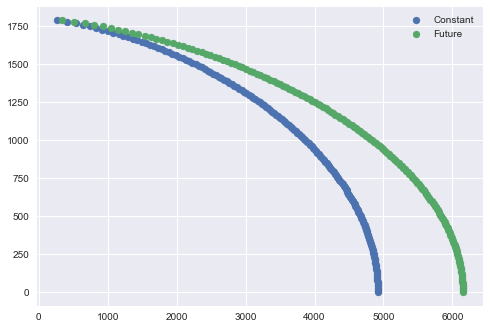

In [19]:
plt.scatter(Q1,Pwf_gen)
plt.scatter(Q2,Pwf_gen)
plt.legend(labels=["Constant","Future"])
plt.show()

## VLP
#### Rsaza and Katz

In [20]:
SG = 0.8
dt = 2.375
rough = 0.0006 #eps/d
L = 8000 #ft
theta = 0 #deg

Ph = 500 #psia
Th = 150+460 #R
Twf = 212+460 #R, same with Tr

fM = (1/(1.74-2*np.log10(2*rough)))**2

In [21]:
Qsc_gen = np.linspace(0,6200,num=len(Pwf_gen)) #MSCFD

In [22]:
def z(Ppr,Tpr):
    Az = 1.39*(Tpr-0.92)**0.5-0.36*Tpr-0.1
    Cz = 0.132 - 0.32*np.log10(Tpr)
    Ez = 9*(Tpr-1)
    Fz = 0.3106 - 0.49*Tpr+0.1824*Tpr**2
    Dz = 10**Fz
    Bz = (0.62-0.23*Tpr)*Ppr +(0.066/(Tpr-0.86)-0.037)*Ppr**2+0.32*Ppr**6/10**Ez

    z = Az + (1-Az)/np.exp(Bz) + Cz * Ppr**Dz
    return z
def obj_func(Pwfg,Qsc):
    P_av = (Ph+Pwfg)/2
    Ppr_n = P_av/Ppc

    T_av = (Th+Twf)/2
    Tpr_n = T_av/Tpc

    cos_th = np.cos(theta/57.3)

    z_av = z(Ppr_n,Tpr_n)

    s = 0.0375*SG*L*cos_th/(z_av*T_av)
    es = np.exp(s)
    obj = Pwfg**2-es*Ph**2-(0.000667*(es-1)*fM*(Qsc**2)*(z_av**2)*(T_av**2))/(dt**5*cos_th)
    return obj

In [23]:
rt = []
for Qsc_iter in Qsc_gen:
    Qsc = Qsc_iter
    a = Ph
    b = Pr2
    fa = obj_func(a,Qsc)
    fb = obj_func(b,Qsc)

    cprev = 2*b-a
    c = a - fa*(b-a)/(fb-fa)
    fc = obj_func(c,Qsc)

    eps = 1e-6
    while abs(fc)>eps:
        if fa*fc<0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
        cprev = c
        c = a - fa*(b-a)/(fb-fa)
        fc = obj_func(c,Qsc)
    rt = rt + [cprev]
rt = np.asarray(rt)

In [24]:
OP = np.where(abs(Pwf_gen-rt)<5)[0][0]

In [25]:
Q1[OP]

4360.056343376149

In [26]:
Q2[OP]

5452.591318838515

In [27]:
Qsc_gen[100]

3463.687150837989

In [28]:
rt[100]

834.7993388525695

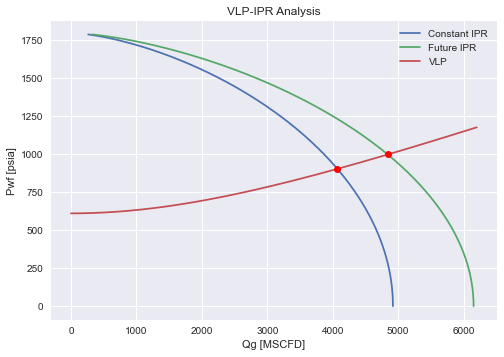

In [61]:
line_1 = LineString(np.column_stack((Q1,Pwf_gen)))
line_2 = LineString(np.column_stack((Q2,Pwf_gen)))
line_3 = LineString(np.column_stack((Qsc_gen,rt)))

intersect1 = line_1.intersection(line_3)
intersect2 = line_2.intersection(line_3)

plt.plot(Q1,Pwf_gen,label="Constant IPR")
plt.plot(Q2,Pwf_gen,label="Future IPR")
plt.plot(Qsc_gen,rt,label="VLP")
plt.plot(*intersect1.xy,'ro')
plt.plot(*intersect2.xy,'ro')

plt.title("VLP-IPR Analysis")
plt.xlabel("Qg [MSCFD]")
plt.ylabel("Pwf [psia]")
plt.legend()
plt.show()

In [30]:
intersect1.x,intersect1.y

(4069.766304358192, 904.4125382170089)

In [31]:
intersect2.x,intersect2.y

(4839.542903785518, 999.1592131894079)

In [63]:
(intersect2.x-intersect1.x)/intersect1.x

0.18914516015403524

### Plateau Rate and Rate Prediction

In [38]:
IGIP = 400 * 1e6 #mscf
p0 = np.array([Pr,14.7])
z0 = z(p0/Ppc,Tpr)
pz00 = p0/z0
grad = (pz00[1]-pz00[0])/IGIP 

In [40]:
P = np.linspace(0,2800,1000)
p_over_z = P/z(P/Ppc,Tpr)

In [41]:
def pz_pr(V):
    if (V == p_over_z).any() == True:
        return(P[V==p_over_z][0])
    else:
        pzo = p_over_z[p_over_z<V][-1]
        pzl = p_over_z[p_over_z>V][0]
        Po = P[p_over_z==pzo][0]
        Pl = P[p_over_z==pzl][0]
        m = (Pl-Po)/(pzl-pzo)
        pres = m*(V-pzo)+Po
        return(pres)

In [42]:
def obj_func2(Ph):
    P_av = (Ph+Pwfg)/2
    Ppr_n = P_av/Ppc

    T_av = (Th+Twf)/2
    Tpr_n = T_av/Tpc

    cos_th = np.cos(theta/57.3)

    z_av = z(Ppr_n,Tpr_n)

    s = 0.0375*SG*L*cos_th/(z_av*T_av)
    es = np.exp(s)
    obj = Pwfg**2-es*Ph**2-(0.000667*(es-1)*fM*(Qsc**2)*(z_av**2)*(T_av**2))/(dt**5*cos_th)
    return obj

In [43]:
year = np.arange(1,70,0.01)
time = year*365
dtime = np.insert(time[1:]-time[:-1],0,time[0],axis=0)
qg_plt = 5000 #mscf/d
qg = np.zeros(len(year))+qg_plt
dGp = dtime*qg
Gp = np.cumsum(dGp)
poverz = grad*Gp+pz00[0]
dpsquared = (qg/C)**(1/n)

pres = []
for ppzz in poverz:
    pres = pres + [pz_pr(ppzz)]
pres = np.asarray(pres)
pwf = (pres**2 - dpsquared)**(1/2)
max(year),min(pwf)

(69.99000000000007, 626.2723227889747)

In [45]:
ptf = []
Qsc = qg_plt
for pwf_iter in pwf:
    Pwfg = pwf_iter
    a = 300
    b = 1000
    fa = obj_func2(a)
    fb = obj_func2(b)

    cprev = 2*b-a
    c = a - fa*(b-a)/(fb-fa)
    fc = obj_func2(c)

    eps = 1e-6
    while abs(fc)>eps:
        if fa*fc<0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
        cprev = c
        c = a - fa*(b-a)/(fb-fa)
        fc = obj_func2(c)
    ptf = ptf + [cprev]
ptf = np.asarray(ptf)

<ipython-input-22-9105ae54b10a>:9: RuntimeWarning: invalid value encountered in double_scalars
  z = Az + (1-Az)/np.exp(Bz) + Cz * Ppr**Dz


In [46]:
dct_pta = {
    "Year" : year,
    "Time" : time,
    "dt" : dtime,
    "Qg" : qg,
    "dGp" : dGp,
    "Gp" : Gp,
    "P/z" : poverz,
    "dP^2" : dpsquared,
    "Pr" : pres,
    "Pwf" : pwf,
    "Ptf" : ptf
}
df_pta = pd.DataFrame(dct_pta)

df_pta_filtered = df_pta
df_pta_filtered = df_pta_filtered.loc[df_pta_filtered["Ptf"]>300]
df_pta_filtered

,Year,Time,dt,Qg,dGp,Gp,P/z,dP^2,Pr,Pwf,Ptf
0,1.00,365.00,365.00,5000.0,1825000.0,1.825000e+06,3387.988787,3.322795e+06,2786.379134,2107.395108,1551.525913
1,1.01,368.65,3.65,5000.0,18250.0,1.843250e+06,3387.834176,3.322795e+06,2786.243133,2107.215285,1551.375505
2,1.02,372.30,3.65,5000.0,18250.0,1.861500e+06,3387.679565,3.322795e+06,2786.107132,2107.035456,1551.225089
3,1.03,375.95,3.65,5000.0,18250.0,1.879750e+06,3387.524955,3.322795e+06,2785.971142,2106.855634,1551.074678
4,1.04,379.60,3.65,5000.0,18250.0,1.898000e+06,3387.370344,3.322795e+06,2785.835241,2106.675925,1550.924358
...,...,...,...,...,...,...,...,...,...,...,...
6005,61.05,22283.25,3.65,5000.0,18250.0,1.114162e+08,2459.550991,3.322795e+06,2032.993004,900.147774,302.612608
6006,61.06,22286.90,3.65,5000.0,18250.0,1.114345e+08,2459.396381,3.322795e+06,2032.874440,899.879964,302.050330
6007,61.07,22290.55,3.65,5000.0,18250.0,1.114527e+08,2459.241770,3.322795e+06,2032.755875,899.612089,301.486963
6008,61.08,22294.20,3.65,5000.0,18250.0,1.114710e+08,2459.087159,3.322795e+06,2032.637311,899.344150,300.922500


In [47]:
def obj_func0(Pwfg,Qsc):
    Ph = 300
    P_av = (Ph+Pwfg)/2
    Ppr_n = P_av/Ppc

    T_av = (Th+Twf)/2
    Tpr_n = T_av/Tpc

    cos_th = np.cos(theta/57.3)

    z_av = z(Ppr_n,Tpr_n)

    s = 0.0375*SG*L*cos_th/(z_av*T_av)
    es = np.exp(s)
    obj = Pwfg**2-es*Ph**2-(0.000667*(es-1)*fM*(Qsc**2)*(z_av**2)*(T_av**2))/(dt**5*cos_th)
    return obj

In [51]:
qg2_list = sorted(np.arange(500,5000,1),reverse=True)
qg2_list = np.asarray(qg2_list)
pwf_ptf300 = []
for qg in qg2_list:
    Qsc = qg
    a = 300
    b = 900
    fa = obj_func0(a,Qsc)
    fb = obj_func0(b,Qsc)

    cprev = 2*b-a
    c = a - fa*(b-a)/(fb-fa)
    fc = obj_func0(c,Qsc)

    eps = 1e-6
    while abs(fc)>eps:
        if fa*fc<0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
        cprev = c
        c = a - fa*(b-a)/(fb-fa)
        fc = obj_func0(c,Qsc)
    pwf_ptf300 = pwf_ptf300 + [cprev]
pwf_ptf300 = np.asarray(pwf_ptf300)
pwf_ptf300[:10]

array([898.76022652, 898.61321232, 898.46620152, 898.31919482,
       898.17219104, 898.0251907 , 897.87819381, 897.73120036,
       897.58421036, 897.43722382])

In [53]:
dpsq_ptf300 = (qg2_list/C)**(1/n)
pr_ptf300 = (dpsq_ptf300 + pwf_ptf300**2)**(1/2)
poverz_ptf300 = pr_ptf300/z(pr_ptf300/Ppc,Tpr)
Gp_ptf300 = (poverz_ptf300-pz00[0])/grad
dGp_ptf300 = np.insert(Gp_ptf300[1:]-Gp_ptf300[:-1],0,Gp_ptf300[0]-df_pta_filtered.iloc[-1,5])

dt_ptf300 = dGp_ptf300/qg2_list
time_ptf300 = np.cumsum(dt_ptf300)+df_pta_filtered.iloc[-1,1]
year_ptf300 = time_ptf300/365

In [54]:
dct_ptb = {
    "Year" : year_ptf300,
    "Time" : time_ptf300,
    "dt" : dt_ptf300,
    "Qg" : qg2_list,
    "dGp" : dGp_ptf300,
    "Gp" : Gp_ptf300,
    "P/z" : poverz_ptf300,
    "dP^2" : dpsq_ptf300,
    "Pr" : pr_ptf300,
    "Pwf" : pwf_ptf300,
    "Ptf" : np.zeros(len(qg2_list))+300
}
df_ptb = pd.DataFrame(dct_ptb)
df_ptb

,Year,Time,dt,Qg,dGp,Gp,P/z,dP^2,Pr,Pwf,Ptf
0,61.122973,22309.884980,12.034980,4999,60162.865935,1.115494e+08,2458.422859,3.321774e+06,2032.127877,898.760227,300.0
1,61.149653,22319.623474,9.738494,4998,48672.991282,1.115981e+08,2458.010510,3.320753e+06,2031.811705,898.613212,300.0
2,61.176341,22329.364497,9.741023,4997,48675.893453,1.116468e+08,2457.598136,3.319733e+06,2031.495524,898.466202,300.0
3,61.203036,22339.108042,9.743545,4996,48678.748375,1.116954e+08,2457.185739,3.318712e+06,2031.179332,898.319195,300.0
4,61.229737,22348.854124,9.746083,4995,48681.682420,1.117441e+08,2456.773316,3.317692e+06,2030.863130,898.172191,300.0
...,...,...,...,...,...,...,...,...,...,...,...
4495,377.592791,137821.368641,87.199248,504,43948.421107,3.410724e+08,513.944117,9.788607e+04,487.767195,374.206849,300.0
4496,377.832040,137908.694692,87.326052,503,43925.003986,3.411164e+08,513.571992,9.758789e+04,487.432697,374.169404,300.0
4497,378.071638,137996.147901,87.453209,502,43901.510769,3.411603e+08,513.200066,9.729003e+04,487.098352,374.132030,300.0
4498,378.311585,138083.728622,87.580721,501,43877.941161,3.412041e+08,512.828340,9.699248e+04,486.764161,374.094726,300.0


In [55]:
df_final = df_pta_filtered.append(df_ptb,ignore_index=True)
df_final

,Year,Time,dt,Qg,dGp,Gp,P/z,dP^2,Pr,Pwf,Ptf
0,1.000000,365.000000,365.000000,5000.0,1.825000e+06,1.825000e+06,3387.988787,3.322795e+06,2786.379134,2107.395108,1551.525913
1,1.010000,368.650000,3.650000,5000.0,1.825000e+04,1.843250e+06,3387.834176,3.322795e+06,2786.243133,2107.215285,1551.375505
2,1.020000,372.300000,3.650000,5000.0,1.825000e+04,1.861500e+06,3387.679565,3.322795e+06,2786.107132,2107.035456,1551.225089
3,1.030000,375.950000,3.650000,5000.0,1.825000e+04,1.879750e+06,3387.524955,3.322795e+06,2785.971142,2106.855634,1551.074678
4,1.040000,379.600000,3.650000,5000.0,1.825000e+04,1.898000e+06,3387.370344,3.322795e+06,2785.835241,2106.675925,1550.924358
...,...,...,...,...,...,...,...,...,...,...,...
10505,377.592791,137821.368641,87.199248,504.0,4.394842e+04,3.410724e+08,513.944117,9.788607e+04,487.767195,374.206849,300.000000
10506,377.832040,137908.694692,87.326052,503.0,4.392500e+04,3.411164e+08,513.571992,9.758789e+04,487.432697,374.169404,300.000000
10507,378.071638,137996.147901,87.453209,502.0,4.390151e+04,3.411603e+08,513.200066,9.729003e+04,487.098352,374.132030,300.000000
10508,378.311585,138083.728622,87.580721,501.0,4.387794e+04,3.412041e+08,512.828340,9.699248e+04,486.764161,374.094726,300.000000


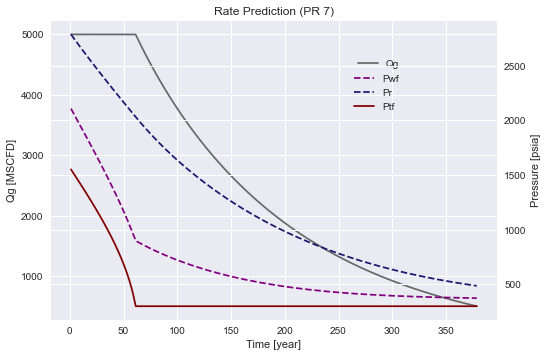

In [56]:
fig,ax1 = plt.subplots()
plt.title("Rate Prediction (PR 7)")
ax2 = ax1.twinx()

ax1.plot(df_final["Year"],df_final["Qg"],linestyle=None,color='dimgray',label='Qg')
ax1.set_xlabel('Time [year]')
ax1.set_ylabel('Qg [MSCFD]')
ax2.plot(df_final["Year"],df_final["Pwf"],linestyle='dashed',color='purple',label='Pwf')
ax2.plot(df_final["Year"],df_final["Pr"],linestyle='dashed',color='midnightblue',label='Pr')
ax2.plot(df_final["Year"],df_final["Ptf"],linestyle=None,color='maroon',label='Ptf')
ax2.set_ylabel('Pressure [psia]')
bbox_to_anchor=(0.6,0.5)
ax2.legend(bbox_to_anchor=(0.8,0.85))
ax1.legend(bbox_to_anchor=(0.8,0.9))
plt.show()

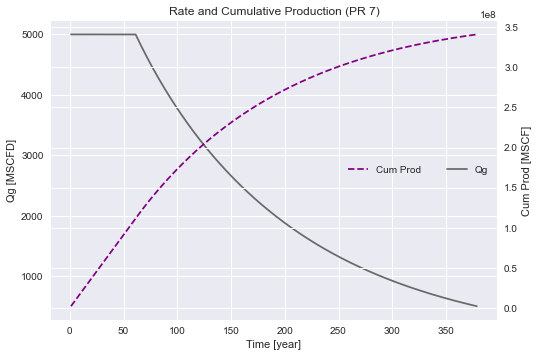

In [57]:
fig,ax1 = plt.subplots()
plt.title("Rate and Cumulative Production (PR 7)")
ax2 = ax1.twinx()

ax1.plot(df_final["Year"],df_final["Qg"],linestyle=None,color='dimgray',label='Qg')
ax1.set_xlabel('Time [year]')
ax1.set_ylabel('Qg [MSCFD]')
ax2.plot(df_final["Year"],df_final["Gp"],linestyle='dashed',color='purple',label='Cum Prod')
ax2.set_ylabel('Cum Prod [MSCF]')

ax1.legend(loc=7)
ax2.legend(loc=5,bbox_to_anchor=(0.85,0.5))
plt.show()

In [58]:
df_final[::500]

,Year,Time,dt,Qg,dGp,Gp,P/z,dP^2,Pr,Pwf,Ptf
0,1.000000,365.000000,365.000000,5000.0,1.825000e+06,1.825000e+06,3387.988787,3.322795e+06,2786.379134,2107.395108,1551.525913
500,6.000000,2190.000000,3.650000,5000.0,1.825000e+04,1.095000e+07,3310.683392,3.322795e+06,2718.989452,2017.451139,1475.990773
1000,11.000000,4015.000000,3.650000,5000.0,1.825000e+04,2.007500e+07,3233.377997,3.322795e+06,2652.721998,1927.210279,1399.487581
1500,16.000000,5840.000000,3.650000,5000.0,1.825000e+04,2.920000e+07,3156.072602,3.322795e+06,2587.484672,1836.377518,1321.570389
2000,21.000000,7665.000000,3.650000,5000.0,1.825000e+04,3.832500e+07,3078.767206,3.322795e+06,2523.190808,1744.619533,1241.700700
2500,26.000000,9490.000000,3.650000,5000.0,1.825000e+04,4.745000e+07,3001.461811,3.322795e+06,2459.757489,1651.548475,1159.202789
3000,31.000000,11315.000000,3.650000,5000.0,1.825000e+04,5.657500e+07,2924.156416,3.322795e+06,2397.105668,1556.701977,1073.194223
3500,36.000000,13140.000000,3.650000,5000.0,1.825000e+04,6.570000e+07,2846.851021,3.322795e+06,2335.159970,1459.512777,982.465180
4000,41.000000,14965.000000,3.650000,5000.0,1.825000e+04,7.482500e+07,2769.545626,3.322795e+06,2273.848179,1359.261198,885.252114
4500,46.000000,16790.000000,3.650000,5000.0,1.825000e+04,8.395000e+07,2692.240231,3.322795e+06,2213.100713,1254.998099,778.766267


In [59]:
print_df = df_final[::500]
print_df.to_excel("Hasil PR7.xlsx",index=False)